<a href="https://colab.research.google.com/github/kairavkkp/ML-Tutorials/blob/autoencoder/Autoencoder/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!nvidia-smi

Thu Mar 25 08:43:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[Link](https://www.tensorflow.org/tutorials/generative/autoencoder) for the original tutorial.

# AutoEncoders

Autoencoder is a neural network that learns to encode the given inputs and tries to recreate the input as the output, minimizing the reconstruction error. Eventually it tries to compress the input data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split as tts
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [49]:
(X_train,_), (X_test,_) = fashion_mnist.load_data()

X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

In [5]:
print(X_train.shape)

(60000, 28, 28)


In [6]:
print(X_test.shape)

(10000, 28, 28)


## Basic Autoencoder

In [8]:
latent_dim = 64

In [15]:
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation = 'relu')
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [16]:
autoencoder = Autoencoder(latent_dim)

In [18]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [19]:
autoencoder.fit(X_train, X_train,
                epochs=10,
                shuffle=True,
                validation_data=(X_test,X_test))

Epoch 1/10
1875/1875 [==============================] - 7s 2ms/step - loss: 0.0401 - val_loss: 0.0131
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0123 - val_loss: 0.0109
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0103 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0094
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.008

In [20]:
encoded_imgs = autoencoder.encoder(X_test).numpy()

In [21]:
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

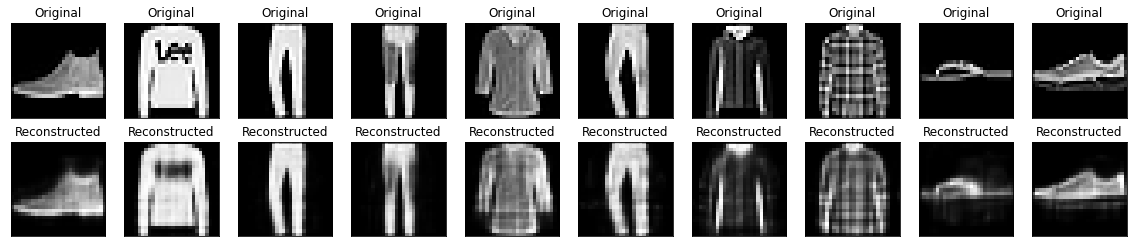

In [24]:
n=10

plt.figure(figsize=(20,4))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(X_test[i])
  plt.title('Original')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title('Reconstructed')
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


## Image Denoising

In [75]:
(X_train,_), (X_test,_) = fashion_mnist.load_data()

X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

In [76]:
noise_factor = 0.2
X_train_noisy = X_train + noise_factor*tf.random.normal(shape=X_train.shape)
X_test_noisy = X_test + noise_factor*tf.random.normal(shape=X_test.shape)

X_train_noisy = tf.clip_by_value(X_train_noisy, clip_value_min=0.0, clip_value_max=1.0)
X_test_noisy = tf.clip_by_value(X_test_noisy, clip_value_min=0.0, clip_value_max=1.0)

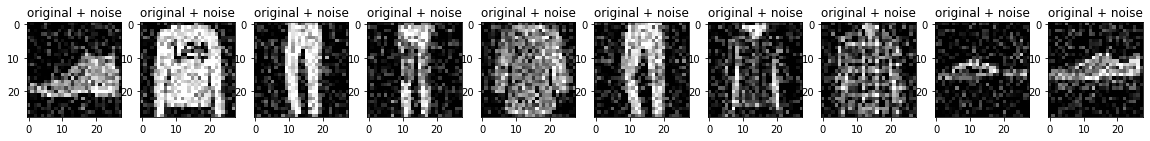

In [77]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(X_test_noisy[i]))
    plt.gray()
plt.show()

In [78]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28,28,1)),
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)
    ])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid',padding='same')
    ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [82]:
denoise = Denoise()

In [83]:
denoise.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [84]:
denoise.fit(X_train_noisy, X_train,
            epochs=10, 
            shuffle=True,
            validation_data=(X_test_noisy,X_test))

Epoch 1/10
1875/1875 [==============================] - 36s 5ms/step - loss: 0.0344 - val_loss: 0.0093
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0087 - val_loss: 0.0080
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.00

In [85]:
denoise.encoder.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [86]:
denoise.decoder.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_12 (Conv2DT (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [87]:
encoded_imgs = denoise.encoder(X_test).numpy()
decoded_imgs = denoise.decoder(encoded_imgs).numpy()

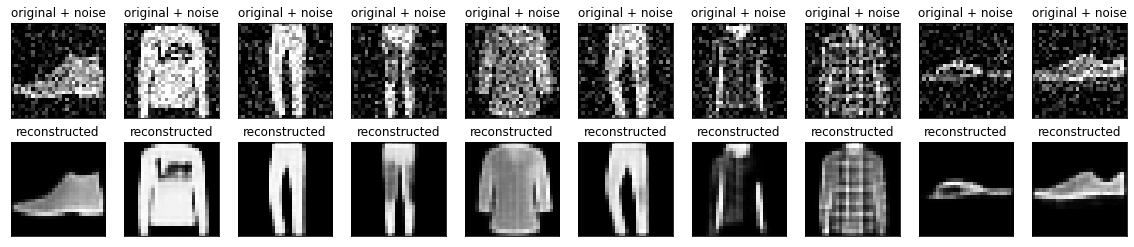

In [88]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(X_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Anomaly Detection

In [89]:
dataset = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [90]:
raw_data = dataset.values

In [92]:
labels = raw_data[:, -1]

data = raw_data[:, :-1]

train_data, test_data, train_labels, test_labels = tts(data, labels, test_size=0.2, random_state=101)

In [93]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = tf.cast((train_data - min_val) / (max_val - min_val),tf.float32)
test_data = tf.cast((test_data - min_val) / (max_val - min_val),tf.float32)


In [94]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

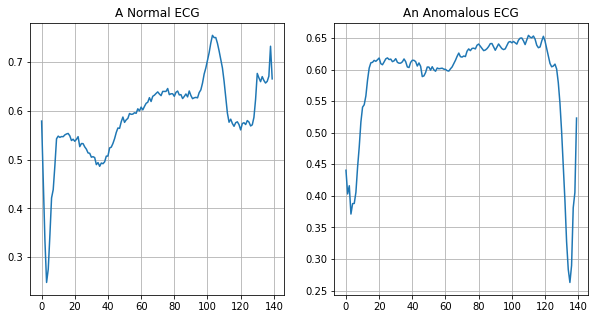

In [100]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")

plt.subplot(1,2,2)
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [103]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(8, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(140, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [104]:
anomaly = AnomalyDetector()

In [105]:
anomaly.compile(optimizer='adam', loss='mae')

Training only on Normal Dataset, but inferencing on whole test dataset

In [106]:
history = anomaly.fit(normal_train_data, normal_train_data,
                      epochs=20,
                      batch_size=512,
                      validation_data=(test_data, test_data),
                      shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 48ms/step - loss: 0.1036 - val_loss: 0.1014
Epoch 2/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0970 - val_loss: 0.0928
Epoch 3/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0884 - val_loss: 0.0835
Epoch 4/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0799 - val_loss: 0.0760
Epoch 5/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0718 - val_loss: 0.0692
Epoch 6/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0638 - val_loss: 0.0624
Epoch 7/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0563 - val_loss: 0.0562
Epoch 8/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0489 - val_loss: 0.0511
Epoch 9/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0429 - val_loss: 0.0474
Epoch 10/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0383 - val_loss: 0.0445
Epoch 11/20
5/5 [============

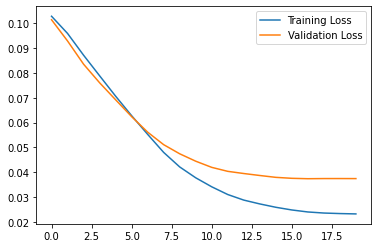

In [107]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Checking on normal Test Data

In [108]:
encoded_ecgs = anomaly.encoder(normal_test_data).numpy()
decoded_ecgs = anomaly.decoder(encoded_ecgs).numpy()

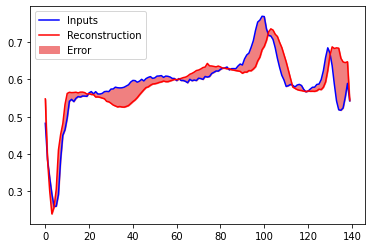

In [109]:
plt.plot(normal_test_data[0],'b')
plt.plot(decoded_ecgs[0],'r')
plt.fill_between(np.arange(140), decoded_ecgs[0], normal_test_data[0], color='lightcoral')
plt.legend(['Inputs', 'Reconstruction', 'Error'])
plt.show()

Checking on anamalous Test Data


In [111]:
encoded_ecgs = anomaly.encoder(anomalous_test_data).numpy()
decoded_ecgs = anomaly.decoder(encoded_ecgs).numpy()

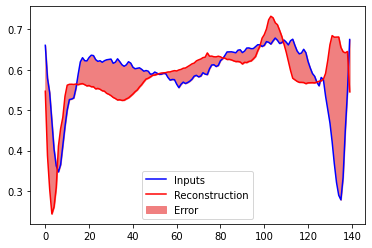

In [113]:
plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_ecgs[0],'r')
plt.fill_between(np.arange(140), decoded_ecgs[0], anomalous_test_data[0], color='lightcoral')
plt.legend(['Inputs', 'Reconstruction', 'Error'])
plt.show()

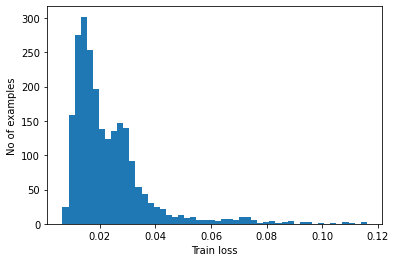

In [116]:
reconstructions = anomaly.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [120]:
threshold = np.mean(train_loss) + np.std(train_loss)
print('Threshold: ',threshold)

Threshold:  0.037399527


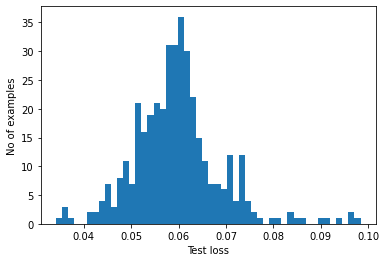

In [118]:
reconstructions = anomaly.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [121]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [123]:
preds = predict(anomaly, test_data, threshold)

In [124]:
print_stats(preds, test_labels)

Accuracy = 0.929
Precision = 0.9927007299270073
Recall = 0.8903436988543372
